## Imports and data loading ##

In [1]:
import os
import pandas as pd
import sqlite3
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

data_directory = 'C:/Users/61407/mental-health-modelling/data'
db = 'mental_health.sqlite'

In [2]:
con = sqlite3.connect(os.path.join(data_directory, db))
cur = con.cursor()

## Schema and data structure ##

In [3]:
tables = cur.execute("""SELECT name FROM sqlite_master WHERE 
            type = 'table'""").fetchall()
print(tables)

[('Answer',), ('Question',), ('Survey',)]


In [4]:
for table_name in tables:
    name = table_name[0]
    table = pd.read_sql_query(f'SELECT * FROM {name}', con)
    print(f'{name} table:')
    print(f'keys: {list(table.columns)}')
    print(f'{table.shape[0]} rows')
    print()

Answer table:
keys: ['AnswerText', 'SurveyID', 'UserID', 'QuestionID']
236898 rows

Question table:
keys: ['questiontext', 'questionid']
105 rows

Survey table:
keys: ['SurveyID', 'Description']
5 rows



## Investigation of questions ##

In [5]:
for index, row in pd.read_sql_query('SELECT * FROM Question', con).iterrows():
    print(f'{row["questionid"]}. {row["questiontext"]}')

1. What is your age?
2. What is your gender?
3. What country do you live in?
4. If you live in the United States, which state or territory do you live in?
5. Are you self-employed?
6. Do you have a family history of mental illness?
7. Have you ever sought treatment for a mental health disorder from a mental health professional?
8. How many employees does your company or organization have?
9. Is your employer primarily a tech company/organization?
10. Does your employer provide mental health benefits as part of healthcare coverage?
11. Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
12. Would you bring up a mental health issue with a potential employer in an interview?
13. Is your primary role within your company related to tech/IT?
14. Do you know the options for mental health care available under your employer-provided health coverage?
15. Has your employer ever formally discussed mental hea

**Some possible questions that could provide a target for classification (i.e. mental health outcome related)**

In [6]:
possible_target_questions = (7,33,34,115,116)
target_questions_df = pd.read_sql_query(f'SELECT * FROM Question WHERE questionid in {possible_target_questions}', con)
for index, rows in target_questions_df.iterrows():
    print(rows.questiontext)

Have you ever sought treatment for a mental health disorder from a mental health professional?
Do you currently have a mental health disorder?
Have you ever been diagnosed with a mental health disorder?
If yes, what condition(s) have you been diagnosed with?
If maybe, what condition(s) do you believe you have?


- How many answers do we have to each of these questions?

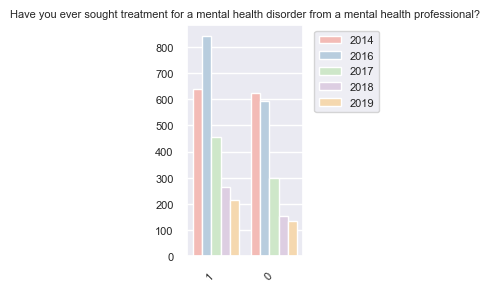

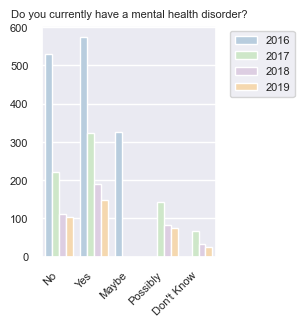

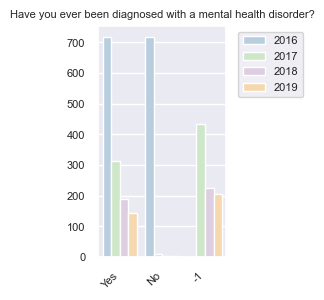

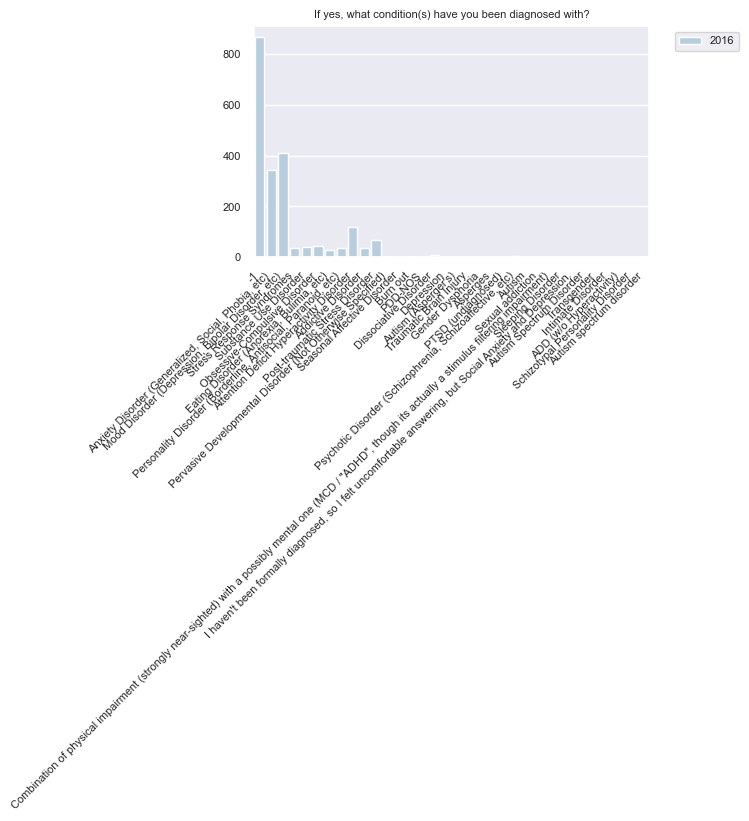

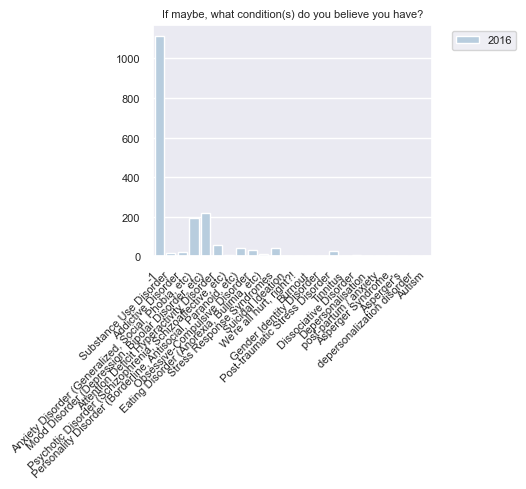

In [7]:
survey_years = pd.read_sql_query('SELECT DISTINCT(SurveyID) FROM Survey', con).values
cmap = plt.get_cmap('Pastel1')
colors_by_year = {int(survey_years[i]):cmap(x) for i, (x) in enumerate(list(range(len(survey_years))))}
sns.set()
for qid in possible_target_questions:
    question = pd.read_sql_query(f'SELECT * FROM Question WHERE QuestionID = {qid}', con)['questiontext'].values
    answer_agg = pd.read_sql_query(f"""SELECT 
                                           AnswerText, SurveyID,
                                       COUNT(*) 
                                           AS 'num'
                                       FROM
                                           Answer
                                       WHERE 
                                           QuestionID = {qid}
                                       GROUP BY
                                           AnswerText, SurveyID
                                   """,
                               con)
    answer = pd.read_sql_query(f"""SELECT *
                                   FROM
                                       Answer
                                   WHERE 
                                       QuestionID = {qid}
                                   """,
                               con)
    fig, ax = plt.subplots(nrows=1, ncols=1,
                           figsize=(0.15*answer_agg.shape[0],3))
    sns.countplot(data=answer, x='AnswerText',
                  stat='count',
                  hue='SurveyID', palette=colors_by_year, saturation=0.8,
                  ax=ax,
               )
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(question[0], fontsize=8)
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left', fontsize=8)
    ax.tick_params(axis='both', labelsize=8)

- Questions that have a relatively robust availability of data:
    1. Have you ever sought treatment for a mental health disorder from a mental health professional?
    2. Do you currently have a mental health disorder?

## Join relevant tables for question 1. ##

In [36]:
q_to_select = 'Have you ever sought treatment for a mental health disorder from a mental health professional?'

## Get all rows from all survey years ##
question1 = pd.read_sql_query(f"""SELECT 
                         Answer.AnswerText, Answer.SurveyID
                     FROM
                         Answer
                     LEFT JOIN
                         Question
                     ON
                         Answer.QuestionID = Question.questionid
                     WHERE
                         Question.questiontext = '{q_to_select}';
                    """, 
                  con)